# Importing the Packages

In [6]:
import pandas as pd
import neattext as nt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

# Reading the Data

In [7]:
df = pd.read_csv('incident.csv')

# Data Preparation

In [8]:
from dateutil import parser
def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False

def clean_data(text):
    text=str(text).lower()
    text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    text = re.sub(r"received from:",' ',text)
    text = re.sub(r"from:",' ',text)
    text = re.sub(r"to:",' ',text)
    text = re.sub(r"subject:",' ',text)
    text = re.sub(r"sent:",' ',text)
    text = re.sub(r"ic:",' ',text)
    text = re.sub(r"cc:",' ',text)
    text = re.sub(r"bcc:",' ',text)
    #Remove email 
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    # Remove Non Dictionary character-TODO
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    #& 
    text = re.sub(r'&;?', 'and',text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    #for name in callers:
     # namelist = [part for part in name.split()]
     # for namepart in namelist: 
      #    text = text.replace(namepart,'')
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text
  


In [9]:
df['combine_description']=df['short_description'] + ' ' + df['description']

In [10]:
df['combine_description_cleanned'] = df['combine_description'].apply(clean_data)

In [11]:
def text_cleaning(text):
    text=nt.fix_contractions(text)
    text=nt.remove_special_characters(text)
    text=nt.remove_stopwords(text)
    text=nt.remove_puncts(text)
    text=nt.remove_bad_quotes(text)
    text=nt.remove_emojis(text)
    text=nt.remove_multiple_spaces(text)
    text=nt.remove_non_ascii(text)
    text=nt.remove_shortwords(text,3)
    return text

In [12]:
df['combine_description_cleanned']=df['combine_description_cleanned'].apply(text_cleaning)

# Word Cloud

In [13]:
description=' '.join(df['combine_description_cleanned'])

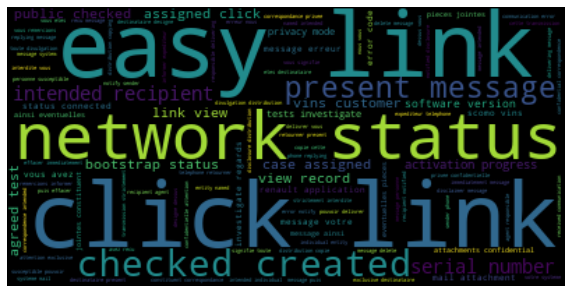

In [14]:
# Create a WordCloud object
wordcloud = WordCloud().generate(description)
plt.figure(figsize=(10, 6))
# Display the generated word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [15]:
new_df=df[['combine_description_cleanned','priority']]

In [16]:
new_df=new_df.dropna(axis=0)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer  #text vectorizing using Tfidf vectorizer

In [18]:
vect=TfidfVectorizer(max_features=4000)  #creating object of tfidf vectorizer

In [19]:
X=vect.fit_transform(new_df['combine_description_cleanned'])  #vectorizing review_body of training reviews

In [20]:
y=new_df.priority

# Imbalance Data

In [21]:
# the given data has imbalace classes so we need to balance that.

c:\users\zee tech\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='priority', ylabel='count'>

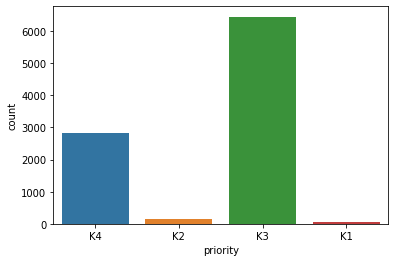

In [22]:
sns.countplot(y)

# Data Balancing (Oversampling)

In [23]:
# we balanced the data by creating synthetic data (oversampling) uisng SMOTE a KNN based method

In [24]:
from imblearn.over_sampling import SMOTE

In [25]:
os=SMOTE()

In [26]:
X,y=os.fit_resample(X,y)

# Balanced Data

c:\users\zee tech\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='priority', ylabel='count'>

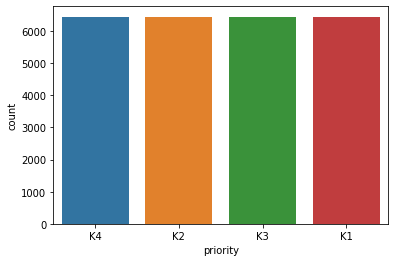

In [27]:
sns.countplot(y)

# Data Split into Training and Testing

In [28]:
from sklearn.model_selection import train_test_split  #importing train test split from sklearn

In [29]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,stratify=y,random_state=42,shuffle=True)

# Models Training

In [ ]:
# Importing Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
# Importing Evaluation matrces
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,\
classification_report, plot_confusion_matrix

# check the performance on diffrent regressor
models = []
models.append(('Support Vector Classifier', svm.SVC()))
models.append(('LogisitcRegression', LogisticRegression()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('Naive Bayes', MultinomialNB()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))


# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)

# metrices to store performance
acc = []
pre = []
f1 = []
con = []
rec = []


import time
i = 0
for name,model in models:
    i = i+1
    start_time = time.time()
    
    # Fitting model to the Training set
    clf = model
    clf.fit(X_train, y_train)
    
    # predict values
    y_pred = clf.predict(X_test)
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    acc.append(accuracy)
    # Precision
    precision = precision_score(y_test, y_pred, average=None)
    pre.append(precision)
    # Recall
    recall = recall_score(y_test, y_pred, average=None)
    rec.append(recall)
    # F1 Score
    f1_sco = f1_score(y_test, y_pred, average=None)
    f1.append(f1_sco)
    # Confusion Matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    con.append(confusion_mat)
    # Report
    report = classification_report(y_test, y_pred)
    
    # evaluate model
    scores = cross_val_score(clf, X, y, cv=cv, n_jobs=-1)



    print("+","="*100,"+")
    print('\033[1m' + f"\t\t\t{i}-For {name} The Performance result is: " + '\033[0m')
    print("+","="*100,"+")
    print('Accuracy : ', accuracy)   
    print("-"*50)
    print('F1 : ', f1_sco)
    print("-"*50)
    print('Reacll : ', recall)
    print("-"*50)
    print('Precision : ', precision)
    print("-"*50)
    print('cross validation accuracy : ', np.mean(scores))
    print("-"*50)
    print('Confusion Matrix....\n', confusion_mat)
    print("-"*50)
    print('Classification Report....\n', report)
    print("-"*50)
    print('Plotting Confusion Matrix...\n')
    plot_confusion_matrix(clf, X_test, y_test)
    plt.xticks(rotation=90)
    plt.show()


    
    print("\t\t\t\t\t\t\t-----------------------------------------------------------")
    print(f"\t\t\t\t\t\t\t Time for detection ({name}) : {round((time.time() - start_time), 3)} seconds...")
    print("\t\t\t\t\t\t\t-----------------------------------------------------------")
    print()
    
pd.DataFrame({"Model": dict(models).keys(), "Accuracy": acc, "Precision": pre, "Recall": rec, "F1_Score": f1, "Confusion Matrix": con})